### **Import Library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import zipfile, os, random
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetV2S, MobileNetV2, ResNet50V2, EfficientNetB0

from sklearn.metrics import confusion_matrix,classification_report
import itertools

from google.colab import drive
from PIL import Image


### **Import Datatset dari Google Drive dan Ekstraksi Dataset**

In [ ]:
drive.mount('/content/drive')
path_to_dataset = '/content/drive/My Drive/dataset/dataset_daun.zip'

zip_file = path_to_dataset
extract_folder = "images"

if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Ekstrak file zip
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File zip telah berhasil diekstrak.")

Mounted at /content/drive
File zip telah berhasil diekstrak.


### **Tahap Preprocessing - Resize Data**

In [ ]:
BASE_DIR = '/content/images/dataset_daun/'

batch_size = 64
img_size = (224,224)

dataset = image_dataset_from_directory(
    BASE_DIR,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)
val_dataset = image_dataset_from_directory(
    BASE_DIR,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)
class_names = dataset.class_names

Found 960 files belonging to 8 classes.
Using 768 files for training.
Found 960 files belonging to 8 classes.
Using 192 files for validation.


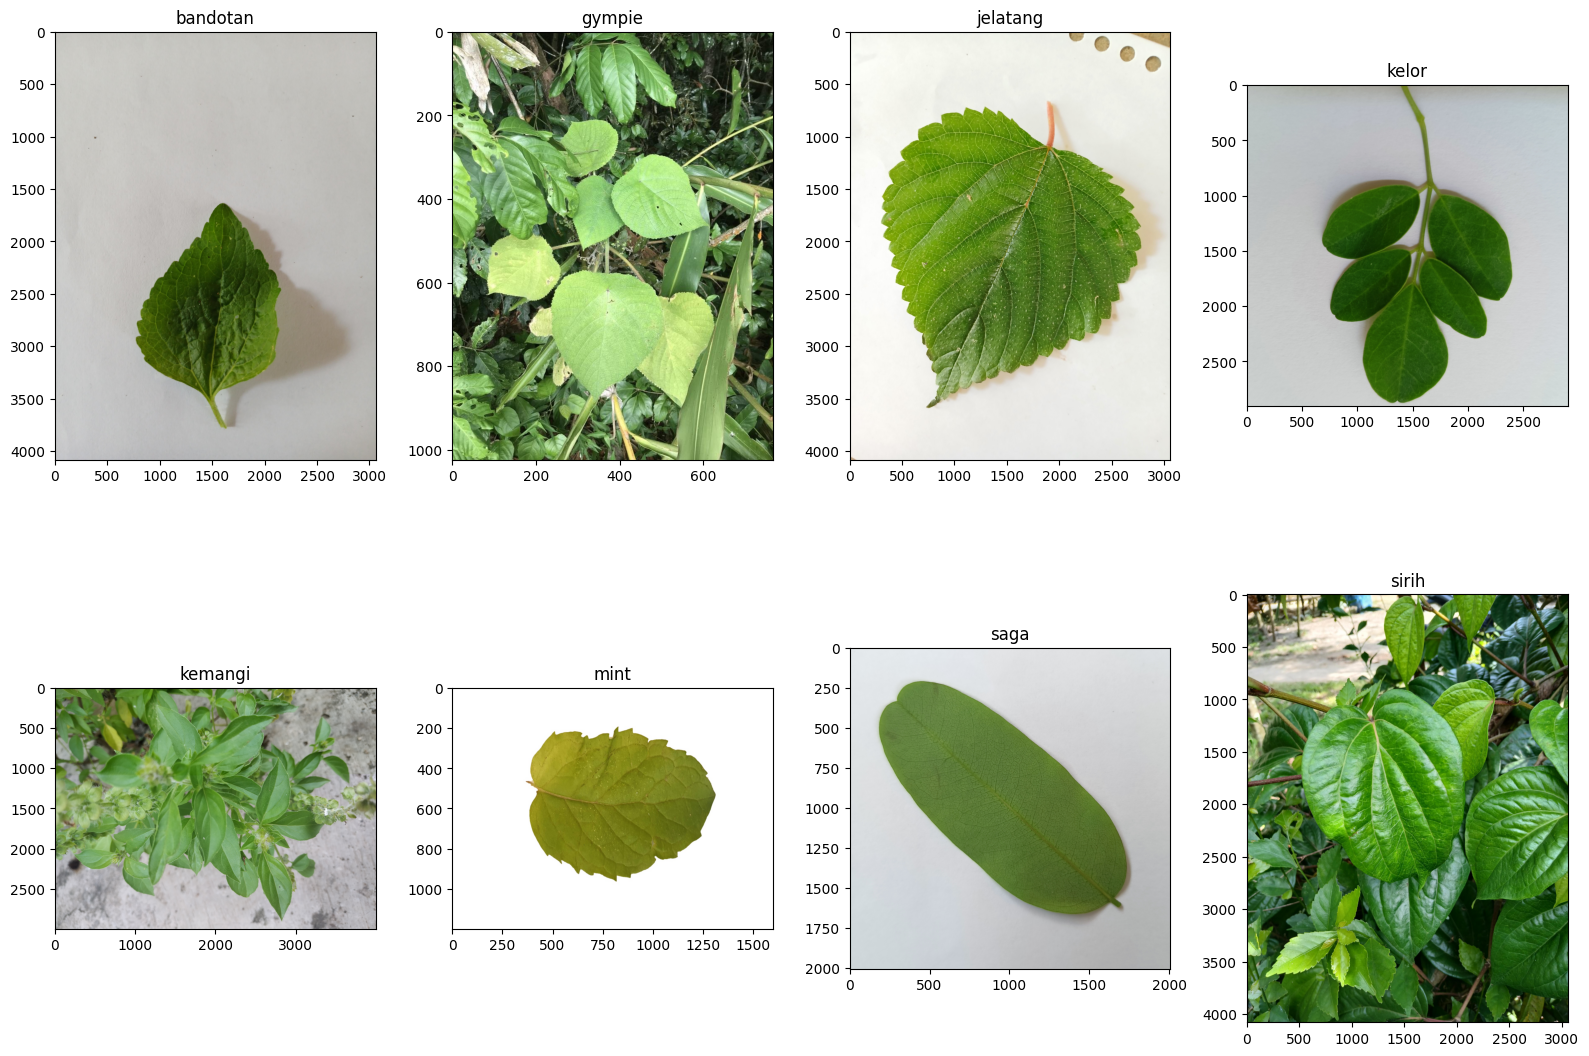

In [ ]:
# === 4. Visualisasi Sampel Data ===
plt.figure(figsize=(16, 12))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(BASE_DIR, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    image = Image.open(image_path)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    # plt.axis("off")
plt.tight_layout()
plt.show()

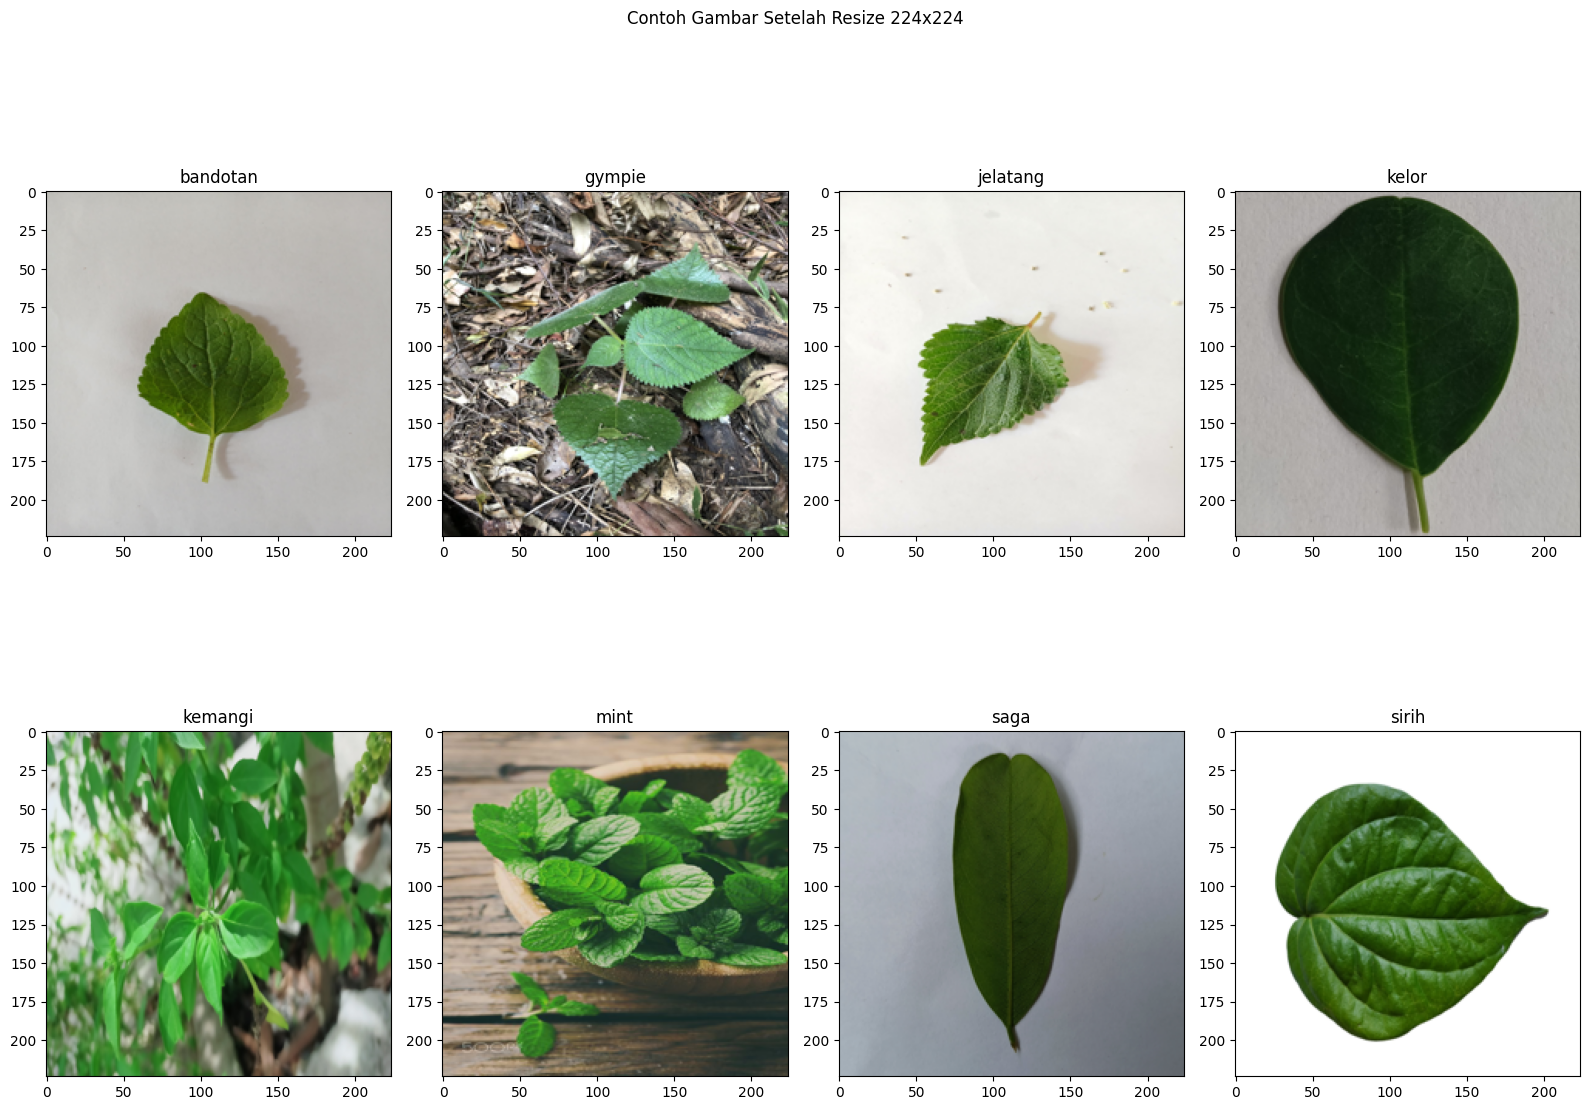

In [ ]:
# === 5. Visualisasi Resize Data ===
plt.figure(figsize=(16, 12))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(BASE_DIR, class_name)
    image_name = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, image_name)
    resized_image = Image.open(image_path).resize(img_size)
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(resized_image)
    plt.title(class_name)
    # plt.axis("off")
plt.tight_layout()
plt.suptitle("Contoh Gambar Setelah Resize 224x224", y=1.02)
plt.show()

In [ ]:
from collections import Counter
import numpy as np

# Fungsi bantu untuk menghitung jumlah label per kelas
def count_labels(dataset):
    labels = []
    for _, batch_labels in dataset.unbatch():
        label_index = np.argmax(batch_labels.numpy())
        labels.append(label_index)
    return Counter(labels)

# Hitung jumlah data per kelas
train_counts = count_labels(dataset)
val_counts = count_labels(val_dataset)

# Tampilkan hasil dalam format tabel
print("Jumlah Data per Kelas:")
print("{:<15} {:<10} {:<10}".format("Kelas", "Train", "Validasi"))
print("-" * 35)
for i, class_name in enumerate(class_names):
    train_count = train_counts.get(i, 0)
    val_count = val_counts.get(i, 0)
    print("{:<15} {:<10} {:<10}".format(class_name, train_count, val_count))


Jumlah Data per Kelas:
Kelas           Train      Validasi  
-----------------------------------
bandotan        93         27        
gympie          98         22        
jelatang        100        20        
kelor           93         27        
kemangi         94         26        
mint            100        20        
saga            89         31        
sirih           101        19        


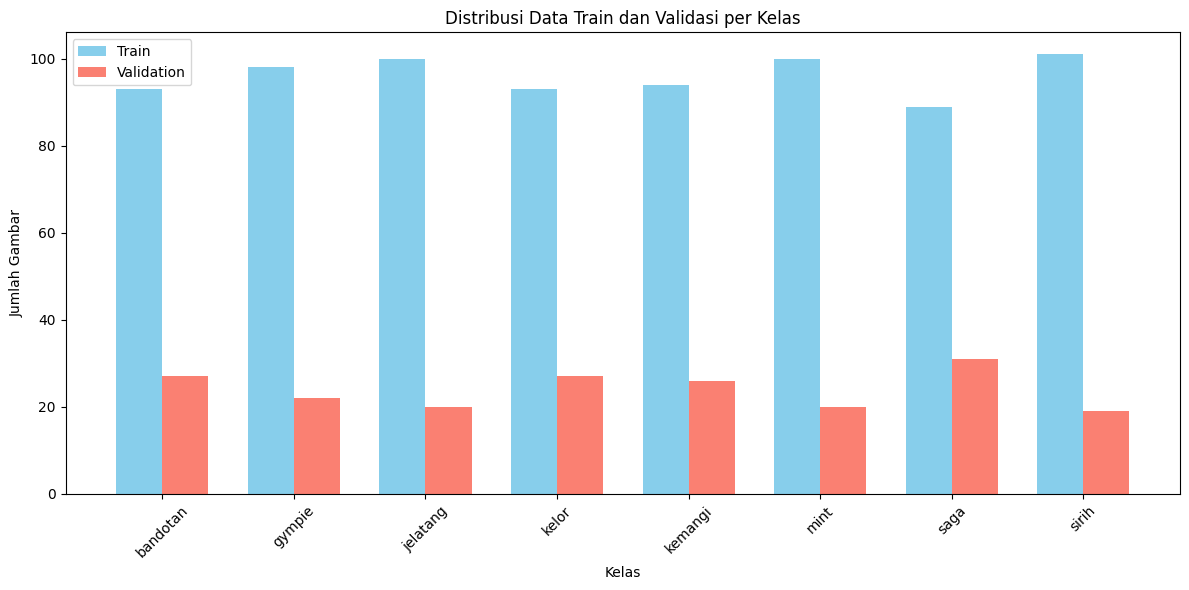

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Fungsi bantu untuk menghitung jumlah label per kelas
def count_labels(dataset):
    labels = []
    for _, batch_labels in dataset.unbatch():
        label_index = np.argmax(batch_labels.numpy())
        labels.append(label_index)
    return Counter(labels)

# Hitung jumlah label per kelas
train_counts = count_labels(dataset)
val_counts = count_labels(val_dataset)

# Ambil jumlah per kelas sesuai urutan class_names
train_values = [train_counts.get(i, 0) for i in range(len(class_names))]
val_values = [val_counts.get(i, 0) for i in range(len(class_names))]

# Visualisasi grafik batang
x = np.arange(len(class_names))  # posisi x untuk setiap kelas
width = 0.35  # lebar batang

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_values, width, label='Train', color='skyblue')
plt.bar(x + width/2, val_values, width, label='Validation', color='salmon')

plt.ylabel('Jumlah Gambar')
plt.xlabel('Kelas')
plt.title('Distribusi Data Train dan Validasi per Kelas')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### **Tahap Preprocessing - Augmentasi Data**

In [ ]:
# === 6. Advanced Augmentation ===
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.GaussianNoise(0.1)
])

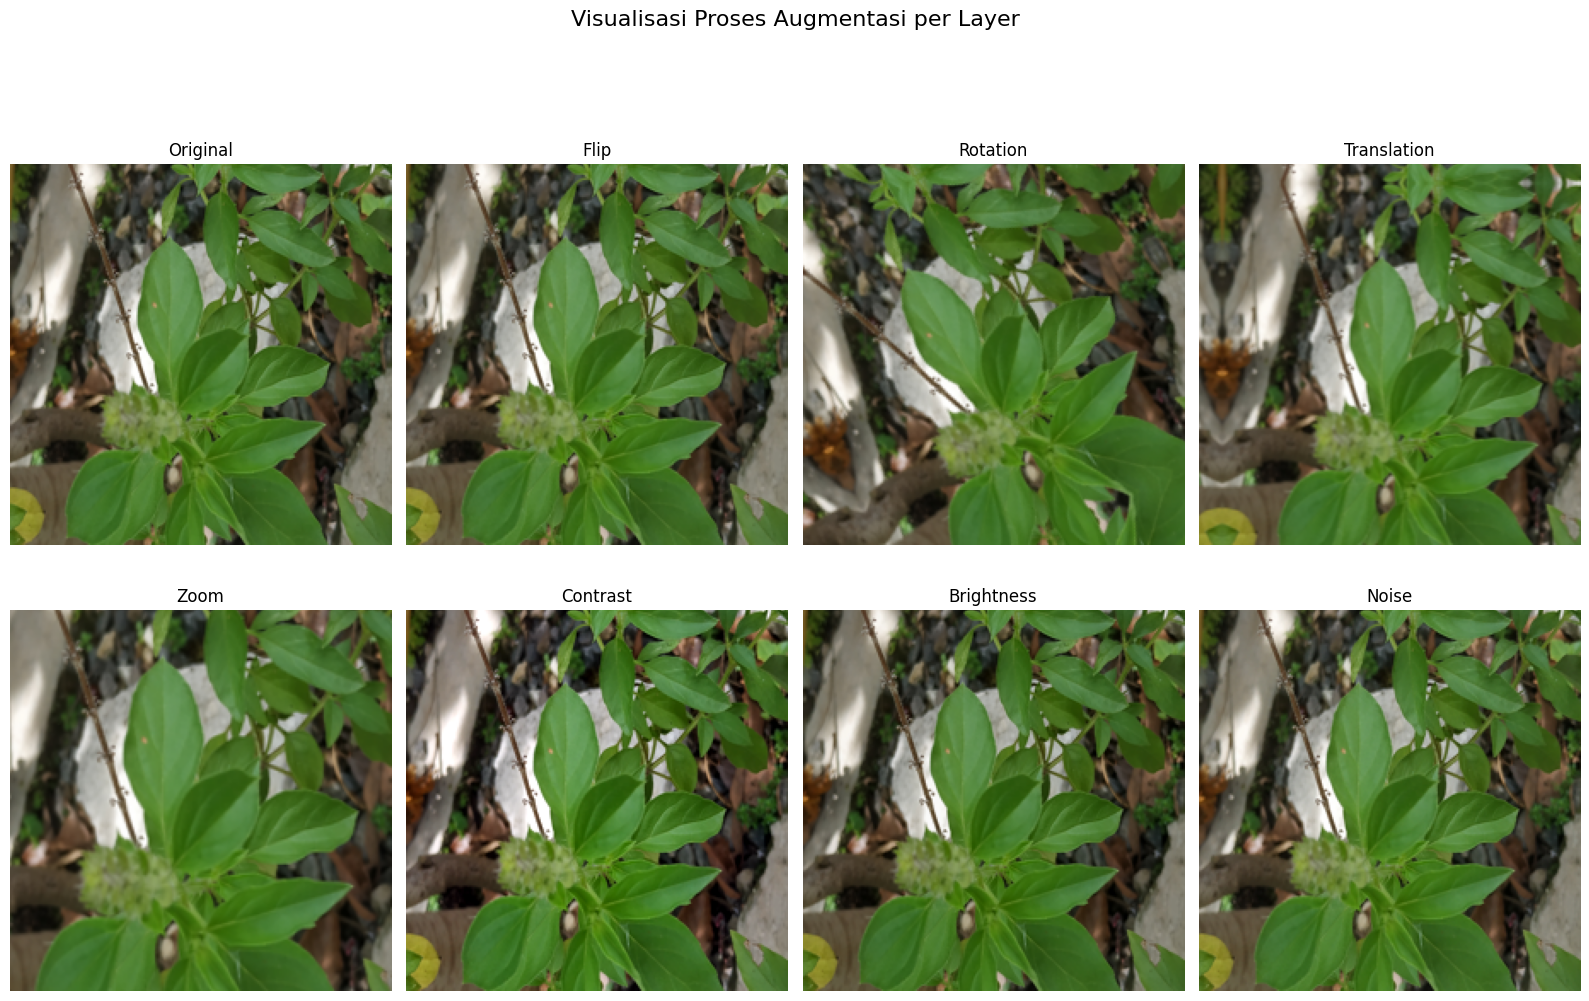

In [ ]:
# === 7. Visualisasi Augmentasi Lengkap dengan Nama Proses ===
sample_class = random.choice(class_names)
sample_path = os.path.join(BASE_DIR, sample_class, random.choice(os.listdir(os.path.join(BASE_DIR, sample_class))))
original_img = Image.open(sample_path).resize(img_size)
img_array = tf.keras.preprocessing.image.img_to_array(original_img)
img_array = tf.expand_dims(img_array, 0)

# Daftar layer dan nama augmentasinya
augmentations = [
    ("Flip", layers.RandomFlip("horizontal")),
    ("Rotation", layers.RandomRotation(0.3)),
    ("Translation", layers.RandomTranslation(0.1, 0.1)),
    ("Zoom", layers.RandomZoom(0.2)),
    ("Contrast", layers.RandomContrast(0.2)),
    ("Brightness", layers.RandomBrightness(0.2)),
    ("Noise", layers.GaussianNoise(0.1))
]

plt.figure(figsize=(16, 10))
plt.subplot(2, 4, 1)
plt.imshow(original_img)
plt.title("Original")
plt.axis("off")

# Terapkan dan tampilkan setiap augmentasi satu per satu
for i, (title, layer) in enumerate(augmentations):
    aug_model = tf.keras.Sequential([layer])
    aug_image = aug_model(img_array, training=True)[0].numpy().astype("uint8")
    plt.subplot(2, 4, i + 2)
    plt.imshow(aug_image)
    plt.title(title)
    plt.axis("off")

plt.suptitle("Visualisasi Proses Augmentasi per Layer", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


### **Arsitektur Model CNN**

In [ ]:
# === 8. Arsitektur Model CNN ===
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_46 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,267,400 (73.50 MB)

 Trainable params: 19,267,400 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

### **Compile dan Training Model**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callback_list = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.3, patience=5, verbose=1)
]

# === Training Model ===
history = model.fit(
    dataset.cache().prefetch(tf.data.AUTOTUNE),
    validation_data=val_dataset.cache().prefetch(tf.data.AUTOTUNE),
    epochs=100,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1220 - loss: 2.4779 - val_accuracy: 0.2188 - val_loss: 2.0214 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.2468 - loss: 1.9569 - val_accuracy: 0.2969 - val_loss: 1.7026 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.2814 - loss: 1.7646 - val_accuracy: 0.3958 - val_loss: 1.6602 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.3692 - loss: 1.5821 - val_accuracy: 0.4062 - val_loss: 1.4405 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.3649 - loss: 1.5444 - val_accuracy: 0.5469 - val_loss: 1.2487 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4504 - loss: 1.3690 - val_accuracy: 0.5208 - val_loss: 1.2177 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5012 - loss: 1.30

### **Download Model**

In [ ]:
model.save('model_costum_64.keras')
print("Model berhasil disimpan sebagai 'model_klasifikasi_daun.keras'")

Model berhasil disimpan sebagai 'model_klasifikasi_daun.keras'


### **Plot Untuk Akurasi dan Loss Model**

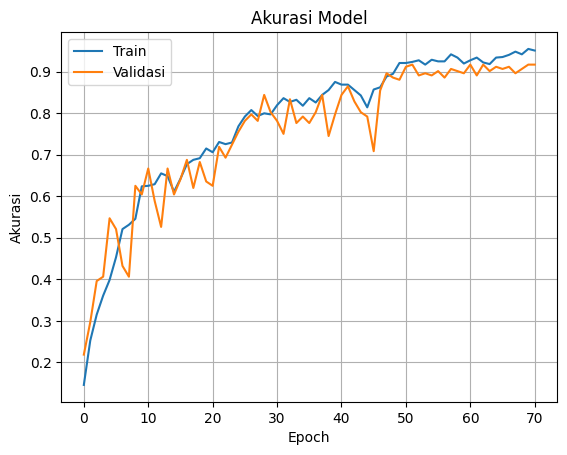

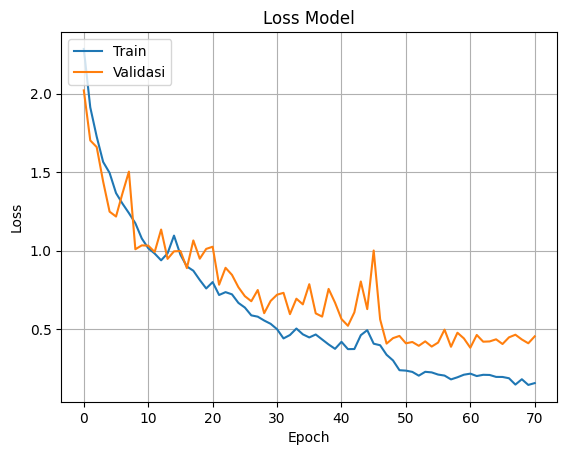

In [ ]:
# === 10. Plot Akurasi dan Loss ===
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validasi'], loc='upper left')
plt.grid(True)
plt.show()

### **Proses Evaluasi pada Data Testing dengan Confusion Matrix**

Confusion matrix, without normalization


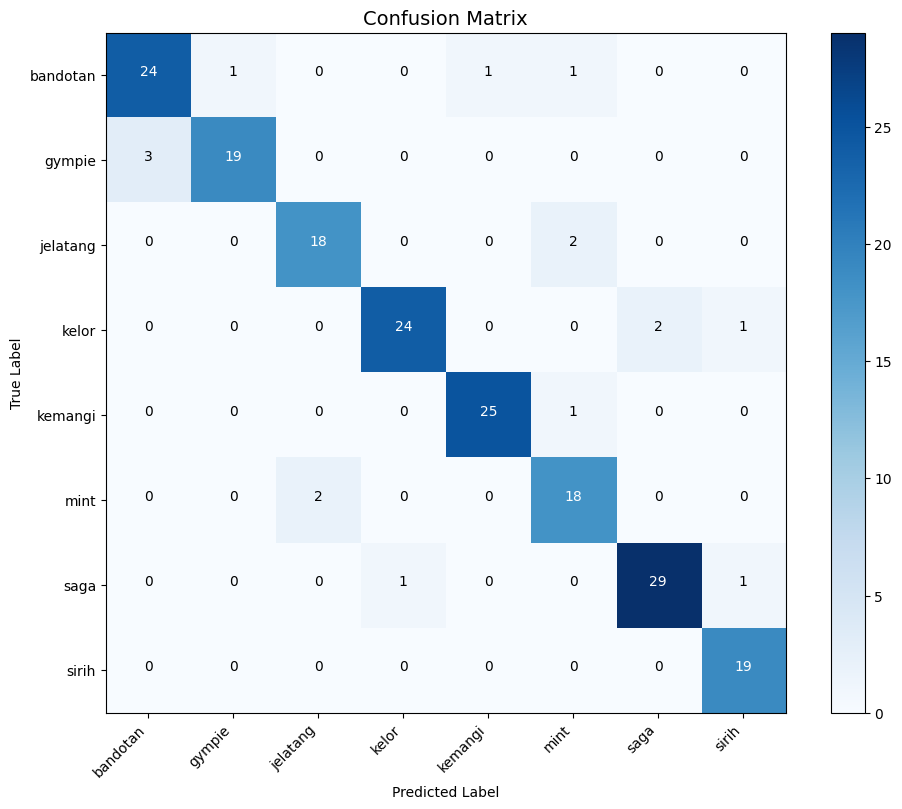

Normalized confusion matrix


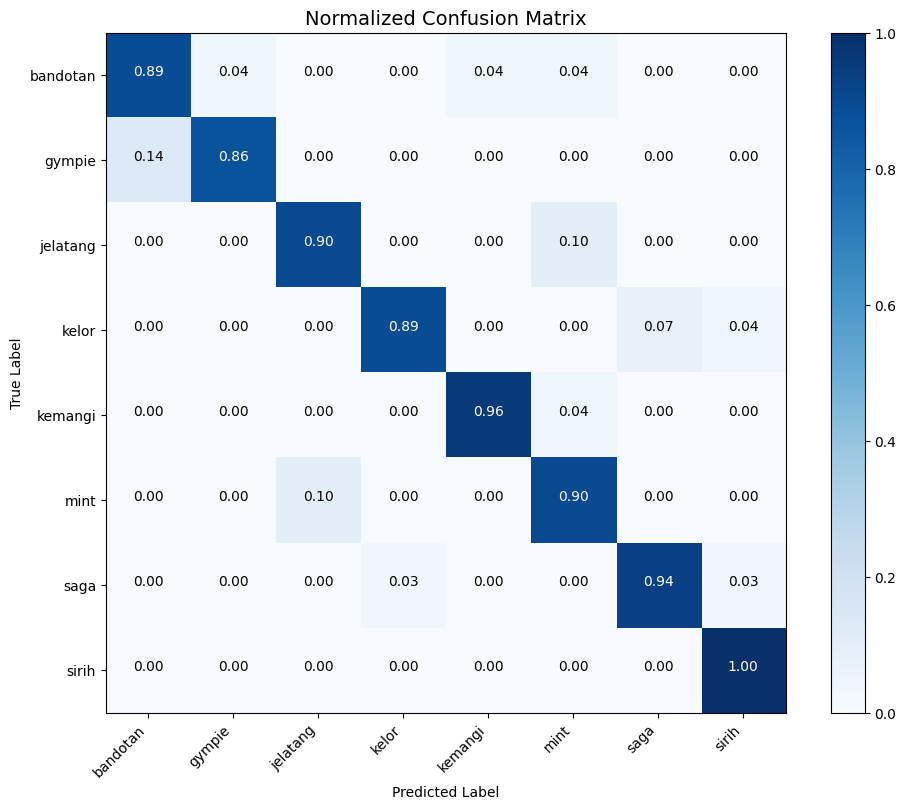


Classification Report:

              precision    recall  f1-score   support

    bandotan       0.89      0.89      0.89        27
      gympie       0.95      0.86      0.90        22
    jelatang       0.90      0.90      0.90        20
       kelor       0.96      0.89      0.92        27
     kemangi       0.96      0.96      0.96        26
        mint       0.82      0.90      0.86        20
        saga       0.94      0.94      0.94        31
       sirih       0.90      1.00      0.95        19

    accuracy                           0.92       192
   macro avg       0.91      0.92      0.92       192
weighted avg       0.92      0.92      0.92       192



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import itertools

# === 11. Evaluasi dengan Confusion Matrix ===
y_pred, y_true = [], []
val_dataset_reset = val_dataset.unbatch().batch(1)

for images, labels in val_dataset_reset:
    pred = model.predict(images, verbose=0)
    y_pred.append(np.argmax(pred, axis=1)[0])
    y_true.append(np.argmax(labels.numpy(), axis=1)[0])

# Hitung confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

# Fungsi untuk menampilkan confusion matrix (termasuk normalisasi yang benar)
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(confusion_mtx, class_names, title='Confusion Matrix')

# Plot normalized confusion matrix
plot_confusion_matrix(confusion_mtx, class_names, normalize=True, title='Normalized Confusion Matrix')

# === 12. Classification Report ===
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
